In [104]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import nltk
import glob
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from scipy.cluster.vq import whiten
%matplotlib inline

nltk.data.path.append('N:\\nltk_data')
sentence_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
word_tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

# Load data
president_file_name = "Donald-Trump.txt"
text = r"./Twitter/tweets/" + president_file_name
folder='./Twitter/tweets/nltk/'
#all_text=[]
tweets=[]
labels = []
for file in os.listdir(folder):
    with open(os.path.join(folder, file)) as f:
        tweets=tweets+f.read().split('\n')
        tweets.pop()
        labels.append(file.strip('.txt'))
all_text = ' '.join(tweets)
    

In [93]:
# create feature vectors
num_tweets = len(tweets)
fvs_lexical = np.zeros((len(tweets), 3), np.float64)
fvs_punct = np.zeros((len(tweets), 3), np.float64)
for e, tw_text in enumerate(tweets):
    # note: the nltk.word_tokenize includes punctuation
    tokens = nltk.word_tokenize(tw_text.lower())
    words = word_tokenizer.tokenize(tw_text.lower())
    sentences = sentence_tokenizer.tokenize(tw_text)
    vocab = set(words)
    words_per_sentence = np.array([len(word_tokenizer.tokenize(s)) for s in sentences])

    # average number of words per sentence
    fvs_lexical[e, 0] = words_per_sentence.mean()
    # sentence length variation
    fvs_lexical[e, 1] = words_per_sentence.std()
    # Lexical diversity
    fvs_lexical[e, 2] = len(vocab) / float(len(words))

    # Commas per sentence
    fvs_punct[e, 0] = tokens.count(',') / float(len(sentences))
    # Semicolons per sentence
    fvs_punct[e, 1] = tokens.count(';') / float(len(sentences))
    # Colons per sentence
    fvs_punct[e, 2] = tokens.count(':') / float(len(sentences))
 
# apply whitening to decorrelate the features
fvs_lexical = whiten(fvs_lexical)
fvs_punct = whiten(fvs_punct)
print(fvs_lexical)

[[  1.43194971   0.42096001  14.48330762]
 [  1.13048661   1.54352004  14.48330762]
 [  3.01463096   0.          14.48330762]
 ..., 
 [  0.90438929   0.          14.48330762]
 [  1.35658393   1.12256003  13.67867942]
 [  1.50731548   2.24512006  14.48330762]]


In [94]:
# get most common words in the whole book
NUM_TOP_WORDS = 10
all_tokens = nltk.word_tokenize(all_text)
fdist = nltk.FreqDist(all_tokens)
vocab = list(fdist.keys())[:NUM_TOP_WORDS]
 
# use sklearn to create the bag for words feature vector for each chapter
vectorizer = CountVectorizer(vocabulary=vocab, tokenizer=nltk.word_tokenize)
fvs_bow = vectorizer.fit_transform(tweets).toarray().astype(np.float64)

# normalise by dividing each row by its Euclidean norm
fvs_bow /= np.c_[np.apply_along_axis(np.linalg.norm, 1, fvs_bow)]
fvs_bow = np.nan_to_num(fvs_bow)

C:\Users\Aaron\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: invalid value encountered in true_divide


In [95]:
# get part of speech for each token in each chapter
def token_to_pos(ch):
    tokens = nltk.word_tokenize(ch)
    return [p[1] for p in nltk.pos_tag(tokens)]
tweets_pos = [token_to_pos(tw) for tw in tweets]
 
# count frequencies for common POS types
pos_list = ['NN', 'NNP', 'DT', 'IN', 'JJ', 'NNS']
fvs_syntax = np.array([[tw.count(pos) for pos in pos_list]
                       for tw in tweets_pos]).astype(np.float64)
 
# normalise by dividing each row by number of tokens in the chapter
fvs_syntax /= np.c_[np.array([len(tw) for tw in tweets_pos])]

In [82]:
print(fvs_bow.shape, fvs_lexical.shape, fvs_syntax.shape, fvs_punct.shape)

(4725, 10) (4725, 3) (4725, 6) (4725, 3)


In [90]:
def PredictAuthors(fvs):
    km = KMeans(n_clusters=3, init='k-means++', n_init=10, verbose=0)
    km.fit(fvs)
 
    return km

C:\Users\Aaron\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:2903: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))
C:\Users\Aaron\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3179: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001BFB69B9F60>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001BFB1047A90>]], dtype=object)

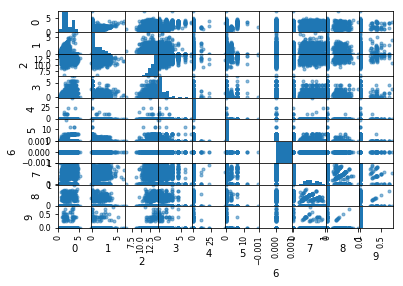

In [110]:
import pandas as pd
fvs = np.c_[fvs_lexical , fvs_punct , fvs_bow, fvs_syntax]
clf = PredictAuthors(fvs)
cl = clf.labels_

attributes=[1,2,3,4,5,6,7,8,9]
'''for a in attributes:
    for b in attributes:
        
        plt.figure()
        plt.scatter(fvs[:,a], fvs[:,b],c=cl, cmap=matplotlib.colors.ListedColormap(['red','blue','yellow']))'''
fvsNew = pd.DataFrame(fvs[:,:10])
pd.scatter_matrix(fvsNew)

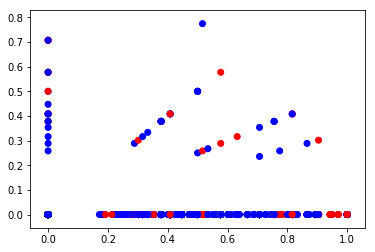

In [113]:
plt.scatter(fvs[:,7], fvs[:,9],c=cl, cmap=matplotlib.colors.ListedColormap(['red','blue','yellow']))


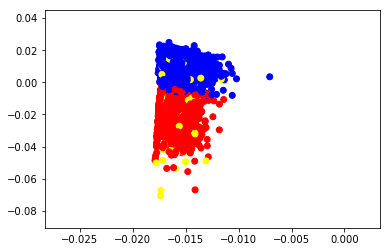

In [114]:
U, s, V = np.linalg.svd(fvs, full_matrices=0)

#table=U[:, 1:3]
plt.scatter(U[:, 0], U[:,1],c=cl, cmap=matplotlib.colors.ListedColormap(['red','blue','yellow']))